# Microsoft challenge

## Set ix

In [ ]:
ix = 0

## Loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#copy data and unzip
!mkdir images
!unzip /content/drive/MyDrive/Microsoft_challenge/Images.zip -d ./images

In [ ]:
#copy annotation & submission files
!cp /content/drive/MyDrive/Microsoft_challenge/Train.csv ./
!cp /content/drive/MyDrive/Microsoft_challenge/Test.csv ./
!cp /content/drive/MyDrive/Microsoft_challenge/SampleSubmission.csv ./

In [ ]:
#check length of images
import glob
len(glob.glob('./images/*')),len(glob.glob('./images/*_rgn*'))

(7630, 3815)

## Defining model

In [ ]:
!pip install --upgrade torchvision

In [ ]:
!pip install timm

In [ ]:
#imports
import cv2
import tqdm
import random
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sb

import torch
import torch.nn.functional as F
from torch import nn, optim, Tensor
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
import timm

def set_seed(seed,data_seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True
  g = torch.Generator()
  g.manual_seed(data_seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  return g

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/common/model_variants_df.csv')
entries = df.iloc[ix]

lr = entries.lr
weight_decay = entries.wd
seed = int(entries.seed)
data_seed = int(entries.data_seed)
rgn = entries.RGN
extra_info = entries.extra_info
done = entries.done
model_name = entries.model_name

if done:
  raise ValueError('Model is cancelled')

img_size = (400,500)
if rgn:
  img_size = (400,400)



In [ ]:
#define model
model_name_list = ['resnet_18','resnet_34','resnet_50','resnet_101','resnet_152',
                   'effnet_s','effnet_m','effnet_l',
                   'convnext_t','convnext_s','convnext_b','convnext_l',
                   'swin_t','swin_s','swin_b',
                   'deit3_s','deit3_b','deit3_l',
                   'coatLite_m','coatLite_t','coatLite_s',
                   'coat_m','coat_t']

def initialize_model(full_name):
  is224 = False
  name,size = full_name.split('_')[0],full_name.split('_')[1]

  if name == 'resnet':
    if size == '18':
      model = models.resnet18(pretrained=True)
      batch_size = 64
    elif size == '34':
      model = models.resnet34(pretrained=True)
      batch_size = 64
    elif size == '50':
      model = models.resnet50(pretrained=True)
      batch_size = 32
    elif size == '101':
      model = models.resnet101(pretrained=True)
      batch_size = 16
    elif size == '152':
      model = models.resnet152(pretrained=True)
      batch_size = 16
    else:
      print(f'{full_name} is not implemented')
    model.fc = nn.Linear(in_features=model.fc.in_features, out_features=3)


  if name == 'effnet':
    if size == 's':
      model = models.efficientnet_v2_s(pretrained=True)
      batch_size = 16
    elif size == 'm':
      model = models.efficientnet_v2_m(pretrained=True)
      batch_size = 8
    elif size == 'l':
      model = models.efficientnet_v2_l(pretrained=True)
      batch_size = 4
    else:
      print(f'{full_name} is not implemented')
    model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=3, bias=True)


  elif name == 'convnext':
    if size == 't':
      model = models.convnext_tiny(pretrained=True)
      batch_size = 16
    elif size == 's':
      model = models.convnext_small(pretrained=True)
      batch_size = 16
    elif size == 'b':
      model = models.convnext_base(pretrained=True)
      batch_size = 8
    elif size == 'l':
      model = models.convnext_large(pretrained=True)
      batch_size = 4
    else:
      print(f'{full_name} is not implemented')
    model.classifier[2] = nn.Linear(in_features=model.classifier[2].in_features, out_features=3, bias=True)


  elif name == 'swin':
    if size == 't':
      model = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1)
      batch_size = 16
    elif size == 's':
      model = models.swin_s(weights=models.Swin_S_Weights.IMAGENET1K_V1)
      batch_size = 16
    elif size == 'b':
      model = models.swin_b(weights=models.Swin_B_Weights.IMAGENET1K_V1)
      batch_size = 8
    else:
      print(f'{full_name} is not implemented')
    model.head = nn.Linear(in_features=model.head.in_features, out_features=3, bias=True)


  elif name == 'deit3':
    is224 = True
    if size == 's':
      model = timm.create_model('deit3_small_patch16_224',pretrained=True)
      batch_size = 128
    elif size == 'b':
      model = timm.create_model('deit3_base_patch16_224',pretrained=True)
      batch_size = 64
    elif size == 'l':
      model = timm.create_model('deit3_large_patch16_224',pretrained=True)
      batch_size = 16
    else:
      print(f'{full_name} is not implemented')
    model.head = nn.Linear(in_features=model.head.in_features, out_features=3, bias=True)


  elif name == 'coatLite':
    if size == 'm':
      model = timm.create_model('coat_lite_mini',pretrained=True,img_size=img_size)
      batch_size = 32
    elif size == 't':
      model = timm.create_model('coat_lite_tiny',pretrained=True,img_size=img_size)
      batch_size = 32
    elif size == 's':
      model = timm.create_model('coat_lite_small',pretrained=True,img_size=img_size)
      batch_size = 16
    else:
      print(f'{full_name} is not implemented')
    model.head = nn.Linear(in_features=model.head.in_features, out_features=3, bias=True)


  elif name == 'coat':
    is224 = True
    if size == 'm':
      model = timm.create_model('coat_mini',pretrained=True)
      batch_size = 32
    elif size == 't':
      model = timm.create_model('coat_tiny',pretrained=True)
      batch_size = 32
    else:
      print(f'{full_name} is not implemented')
    model.head = nn.Linear(in_features=model.head.in_features, out_features=3, bias=True)


  if torch.cuda.is_available():
    model = model.cuda()
  return model,batch_size,is224
model,batch_size,is224 = initialize_model(model_name)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training

In [ ]:
#defining data class
class data_set(Dataset):
    def __init__(self,is224,rgn,test=False):
        self.is224 = is224
        self.rgn = rgn
        #load data
        train_df = pd.read_csv('/content/Train.csv')
        test_df = pd.read_csv('/content/Test.csv')

        start_ix = 0
        if rgn:
          start_ix = 1

        if test:
          self.labels =  test_df['Image_id'].values[::2]
          self.images = test_df['Image_id'].values[start_ix::2]

        else:
          self.labels =  train_df['Label'].replace({'blast':0,'brown':1,'healthy':2}).values[::2]
          self.images = train_df['Image_id'].values[start_ix::2]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image_path = './images/' + self.images[index]
        image = cv2.imread(image_path)
        if self.is224:
          image = cv2.resize(image,(224,224))
        elif self.rgn:
          image = cv2.resize(image,(400,400))
        image = image.transpose(2,0,1)
        label = self.labels[index]
        return image,label

In [ ]:
#training (No CV - Multi-seed)
#hyper-parameters values

#data_seeds = [0,1,9]
g = set_seed(seed,data_seed)
print('='*20,'SEED ',data_seed,'='*20)
model,batch_size,is224 = initialize_model(model_name)

num_epochs = 30

#dataloader, optimizer, scheduler, cost function
optimizer = optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 2,factor=0.1)

DataSet = data_set(is224,rgn)
train_DataSet, val_DataSet = random_split(DataSet,[2136,534],generator=g)
train_loader = DataLoader(train_DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)
val_loader = DataLoader(val_DataSet, batch_size=batch_size, shuffle=True, drop_last=False, generator=g)

loss_fn = nn.CrossEntropyLoss()

#training loop
train_loss_epochs = []
val_loss_epochs = []

for epoch in range(0,num_epochs):
  print('-'*10,f"Epoch :{epoch+1}/{num_epochs}",'-'*10)
  print('learning rate: ',optimizer.param_groups[0]["lr"])

  #train
  losses=[]
  model.train()
  for imgs,labels in tqdm.tqdm(train_loader):
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #forward
    preds = model(imgs.float())
    #loss and backward
    optimizer.zero_grad()
    loss = loss_fn(preds,labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().cpu())
  avg_loss = np.mean(losses)
  print('train loss: ',avg_loss)
  train_loss_epochs.append(avg_loss)
  scheduler.step(avg_loss)

  #validation
  val_losses=[]
  model.eval()
  with torch.no_grad():
    for imgs,labels in val_loader:
      if torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      preds = model(imgs.float())
      val_loss = loss_fn(preds,labels)
      val_losses.append(val_loss.detach().cpu())
  val_losses[-1] = val_losses[-1]*len(preds)/batch_size
  avg_val_loss = np.mean(val_losses)
  print('validation loss: ',avg_val_loss)
  val_loss_epochs.append(avg_val_loss)

  #save best model
  if np.sum(avg_val_loss < np.array(val_loss_epochs))==len(val_loss_epochs)-1 :
    checkpoint_dict = {'model':model.state_dict()}
    torch.save(checkpoint_dict, f'best_model-{data_seed}.pth')

best_epoch = np.argmin(val_loss_epochs)
print('best-val',val_loss_epochs[best_epoch])


==================== SEED  9 ====================


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


---------- Epoch :1/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:51<00:00,  3.36s/it]


train loss:  0.78773147
validation loss:  0.637476
---------- Epoch :2/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:39<00:00,  3.00s/it]


train loss:  0.27677092
validation loss:  0.52599156
---------- Epoch :3/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:38<00:00,  2.99s/it]


train loss:  0.07403968
validation loss:  0.5401815
---------- Epoch :4/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:38<00:00,  2.98s/it]


train loss:  0.026700636
validation loss:  0.51563996
---------- Epoch :5/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:38<00:00,  2.97s/it]


train loss:  0.01142133
validation loss:  0.4762348
---------- Epoch :6/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:37<00:00,  2.96s/it]


train loss:  0.0070815883
validation loss:  0.5095187
---------- Epoch :7/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:38<00:00,  2.97s/it]


train loss:  0.005812891
validation loss:  0.5098127
---------- Epoch :8/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:37<00:00,  2.96s/it]


train loss:  0.0033738622
validation loss:  0.49925232
---------- Epoch :9/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:37<00:00,  2.96s/it]


train loss:  0.0029096757
validation loss:  0.5078765
---------- Epoch :10/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:37<00:00,  2.96s/it]


train loss:  0.0025030798
validation loss:  0.51994824
---------- Epoch :11/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:39<00:00,  3.01s/it]


train loss:  0.0020207951
validation loss:  0.5135454
---------- Epoch :12/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:38<00:00,  2.97s/it]


train loss:  0.001990409
validation loss:  0.51053923
---------- Epoch :13/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:38<00:00,  2.98s/it]


train loss:  0.0016173666
validation loss:  0.51549715
---------- Epoch :14/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:38<00:00,  2.99s/it]


train loss:  0.001579777
validation loss:  0.5052712
---------- Epoch :15/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:38<00:00,  2.98s/it]


train loss:  0.001553243
validation loss:  0.50860316
---------- Epoch :16/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:38<00:00,  2.98s/it]


train loss:  0.0011622055
validation loss:  0.51229405
---------- Epoch :17/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:38<00:00,  2.98s/it]


train loss:  0.00096960197
validation loss:  0.51488966
---------- Epoch :18/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:38<00:00,  2.98s/it]


train loss:  0.0010813789
validation loss:  0.53677386
---------- Epoch :19/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:39<00:00,  3.02s/it]


train loss:  0.0008462753
validation loss:  0.5228804
---------- Epoch :20/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:41<00:00,  3.09s/it]


train loss:  0.0007896209
validation loss:  0.5248122
---------- Epoch :21/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:41<00:00,  3.08s/it]


train loss:  0.00084591645
validation loss:  0.5280893
---------- Epoch :22/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:41<00:00,  3.09s/it]


train loss:  0.00066808116
validation loss:  0.534764
---------- Epoch :23/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:42<00:00,  3.11s/it]


train loss:  0.0005656322
validation loss:  0.52916855
---------- Epoch :24/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:41<00:00,  3.09s/it]


train loss:  0.00061301485
validation loss:  0.5291526
---------- Epoch :25/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:41<00:00,  3.08s/it]


train loss:  0.0009734258
validation loss:  0.5957371
---------- Epoch :26/30 ----------
learning rate:  0.0001


100%|██████████| 33/33 [01:41<00:00,  3.07s/it]


train loss:  0.00057731813
validation loss:  0.53952366
---------- Epoch :27/30 ----------
learning rate:  1e-05


100%|██████████| 33/33 [01:41<00:00,  3.08s/it]


train loss:  0.0005781056
validation loss:  0.5419378
---------- Epoch :28/30 ----------
learning rate:  1e-05


100%|██████████| 33/33 [01:40<00:00,  3.05s/it]


train loss:  0.0003923218
validation loss:  0.53865504
---------- Epoch :29/30 ----------
learning rate:  1e-05


100%|██████████| 33/33 [01:41<00:00,  3.08s/it]


train loss:  0.0006399151
validation loss:  0.55078083
---------- Epoch :30/30 ----------
learning rate:  1e-05


100%|██████████| 33/33 [01:41<00:00,  3.08s/it]


train loss:  0.00052865624
validation loss:  0.53762245
best-val 0.4762348


## Analyze results

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


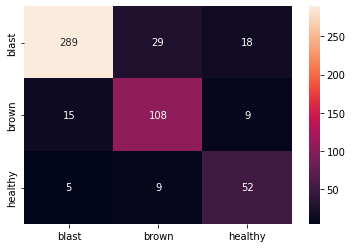

validation loss:  0.47623476
validation accuracy:  84.08239700374533


In [ ]:

#re-validate and test
#reload model
g = set_seed(seed,data_seed)
model,_,_ = initialize_model(model_name)
checkpoint_dict = torch.load(f'best_model-{data_seed}.pth')
model.load_state_dict(checkpoint_dict['model'])

#re-validate
DataSet = data_set(is224,rgn)
train_DataSet, val_DataSet = random_split(DataSet,[2136,534], generator=g)
train_loader = DataLoader(train_DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)
val_loader = DataLoader(val_DataSet, batch_size=batch_size, shuffle=True, drop_last=False, generator=g)

val_losses=[]
tot_preds=[]
tot_labels=[]
preds_values=[]
true_preds_tot = 0
val_len_data = val_DataSet.__len__()

model.eval()
with torch.no_grad():
  for imgs,labels in val_loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    preds = model(imgs.float())
    preds_values.extend(preds.detach().cpu().numpy())
    tot_preds.extend(torch.max(preds,axis=1).indices.detach().cpu().numpy().tolist())
    tot_labels.extend(labels.detach().cpu().numpy().tolist())
    val_loss = loss_fn(preds,labels)
    val_losses.append(val_loss.detach().cpu())
    true_preds = (torch.max(preds,axis=1).indices == labels).sum()
    true_preds_tot += true_preds
val_losses[-1] = val_losses[-1]*len(preds)/batch_size
avg_val_loss = np.mean(val_losses)
val_acc = 100*(true_preds_tot.cpu().numpy()/val_len_data)

#confusion matrix
cf_matrix = confusion_matrix(tot_preds, tot_labels)
df_cm = pd.DataFrame(cf_matrix, index = ['blast','brown','healthy'],
                    columns = ['blast','brown','healthy'])
sb.heatmap(df_cm, annot=True,fmt='.3g');
plt.show()
print('validation loss: ',avg_val_loss)
print('validation accuracy: ',val_acc)


## Compare

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#save some info for comparison
df = pd.read_csv('/content/drive/MyDrive/common/model_variants_df.csv')
df['train_score'].iloc[ix] = train_loss_epochs[-1]
df['last_val_score'].iloc[ix] = np.sort(val_loss_epochs)[1:6].mean()
df['best_val_score'].iloc[ix] = val_loss_epochs[best_epoch]
df['best_val_acc'].iloc[ix] = val_acc
df['done'].iloc[ix] = True

rgn_string = ''
if rgn:
  rgn_string = '_rgn'
if np.isnan(extra_info):
 extra_info = ''
np.save('/content/drive/MyDrive/Microsoft_challenge/results/'+model_name+extra_info+'_'+str(data_seed)+rgn_string+'_val_preds.npy',preds_values)
df.to_csv('/content/drive/MyDrive/common/model_variants_df.csv', index = False)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## Submission

In [ ]:
#test
ss_df = pd.read_csv('/content/SampleSubmission.csv')

test_DataSet = data_set(is224,rgn,test=True)
test_loader = DataLoader(test_DataSet, batch_size=batch_size)

checkpoint_dict = torch.load(f'best_model-{data_seed}.pth')
model.load_state_dict(checkpoint_dict['model'])

model.eval()
softmax = nn.Softmax(dim=1)
with torch.no_grad():
  for imgs,labels in test_loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
    preds = model(imgs.float())
    preds = softmax(preds).cpu().numpy()

    for i,label in enumerate(labels):
      ss_df.loc[ss_df.Image_id==label,['blast','brown','healthy']] = preds[i]
ss_df.to_csv('/content/drive/MyDrive/Microsoft_challenge/results/'+model_name+extra_info+rgn_string+f'_subm-{data_seed}.csv', index = False)


In [ ]:
ss_df.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.996923,0.002602,0.000475
1,id_01hu05mtch.jpg,0.098114,0.836526,0.065360
2,id_030ln10ewn.jpg,0.983165,0.014047,0.002789
3,id_03z57m8xht.jpg,0.998406,0.000097,0.001496
4,id_04ngep1w4b.jpg,0.998432,0.000411,0.001157
